# Models

## Common Code

Common functions for training and fine-tuning the BERT models.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
print("INIT module_path: ", module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

DATA_DIR = module_path + "/data"
MODEL_DIR = module_path + "/model"

for data_dir in [DATA_DIR, MODEL_DIR]:
    os.makedirs(data_dir, exist_ok=True)

INIT module_path:  c:\Users\Alan\Desktop\Open_Source\BERT-TLSA-paper


In [2]:
from transformers import BertTokenizerFast, BertForMaskedLM, BertModel, BertConfig
import torch
import torch.nn as nn
from typing import cast

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


class BERTSentimentClassifier(nn.Module):
    def __init__(self, bert: BertModel, n_classes: int):
        super().__init__()
        self.bert = bert
        self.drop = nn.Dropout(p=0.3)
        self.linear = nn.Linear(bert.config.hidden_size, 1), # Convert from the hidden state to a single output
    
    def forward(self, input_ids: torch.IntTensor, attention_mask: torch.IntTensor) -> torch.FloatTensor:
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # https://huggingface.co/transformers/v3.2.0/model_doc/bert.html
        # Pooler output is last layer of hidden state for [CLS] token, whose
        # output is fed through a linear layer and a tanh function
        #
        # Shape of (batch_size, hidden_size) 
        dropout_output: torch.FloatTensor = self.drop(bert_output.pooler_output)
        return self.linear(dropout_output)


class TrainingConfig:
    def __init__(self, tokenizer: BertTokenizerFast = None, pretrained_tokenizer_name: str = "bert-base-uncased", pretrained_model_name: str = "", stop_delta: float = 0.01, stop_patience: int = 5, name: str = "model", train_bert_in_finetune: bool = True, max_token_length: int = 512, class_names: list[str] = ["negative", "neutral", "positive"]):
        if tokenizer != None:
            self.tokenizer = tokenizer
        else:
            self.tokenizer = BertTokenizerFast.from_pretrained(pretrained_tokenizer_name)
        
        self.pretrained_model_name = pretrained_model_name
        self.name = name
        # Number of output classes
        self.class_names = class_names
        # How much of a delta counts as an improvement. See TrainEarlyStopping.
        self.stop_delta = stop_delta
        # Number of epochs to wait for an improvement before stopping training. See TrainEarlyStopping.
        self.stop_patience = stop_patience
        # The final pretrained model, after pretraining
        self.pretrained_model = cast(BertModel, None)
        # The final classifier model, after finetuning
        self.finetuned_classifier_model = cast(BERTSentimentClassifier, None)
        # Whether to include the base bert parameters in finetuning
        # This increases training time, but could potentially lead to better performance
        self.train_bert_in_finetune = train_bert_in_finetune
        self.max_token_length = max_token_length

    def __str__(self):
        return str(self.__dict__)
    
    def __repr__(self):
        return str(self)


print(f"Training on device: {device}")

Training on device: cuda


In [3]:
from transformers import BertTokenizerFast
import pandas as pd
import torch
from typing import TypedDict, cast
import numpy as np
import seaborn as sns


def move_dict_to(res: dict, device: torch.device):
    for key in res:
        if isinstance(res[key], torch.Tensor):
            res[key] = cast(torch.Tensor, res[key]).to(device=device)


class TokenizedInputs(TypedDict):
    input_ids: torch.IntTensor
    token_type_ids: torch.IntTensor
    attention_mask: torch.IntTensor
    labels: torch.IntTensor


class MaskedTextDatasetItem(TokenizedInputs):
    original_text: str


class MaskedTextDataset(torch.utils.data.Dataset[MaskedTextDatasetItem]):
    """
    Dataset of masked text
    """
    def __init__(self, encodings: TokenizedInputs, original_text: list[str] = None, batch_device: torch.device = None):
        self.encodings = encodings
        self.original_text = original_text
        self.batch_device = batch_device

    def __getitem__(self, index: int) -> MaskedTextDatasetItem:
        # Return the dictionary just like encodings, except it only
        # contains the entries for a specific row (sentence)
        res = {key: val[index] for key, val in self.encodings.items() }
        if self.original_text:
            res["original_text"] = self.original_text[index]
        # If output_device is set, we move individual batches to the device
        if self.batch_device:
            move_dict_to(res, self.batch_device)
        return res
    
    def __len__(self):
        return len(self.encodings["input_ids"])


class ReviewsDatasetItem(TokenizedInputs):
    original_text: str
    score: int


class ReviewsDataset(torch.utils.data.Dataset[ReviewsDatasetItem]):
    """
    Dataset of reviews and their normaliezd scores (decimal number from 0 to 1)
    """
    def __init__(self, encodings: TokenizedInputs, scores: list[int], max_score: int, original_text: list[str] = None, batch_device: torch.device = None):
        self.encodings = encodings
        self.scores = scores
        self.max_score = max_score
        self.original_text = original_text
        self.batch_device = batch_device
    
    def __getitem__(self, index: int) -> ReviewsDatasetItem:
        # Return the dictionary just like encodings, except it only
        # contains the entries for a specific row (sentence)
        res = {key: val[index] for key, val in self.encodings.items() }
        if self.original_text:
            res["original_text"] = self.original_text[index]
        res["score"] = self.scores[index]
        # If output_device is set, we move individual batches to the device
        if self.batch_device:
            move_dict_to(res, self.batch_device)
        return res

    def __len__(self):
        return len(self.encodings["input_ids"])


def get_masked_dataset(tokenizer: BertTokenizerFast, review_texts: list[str], percent_masked: float = 0.15, max_token_length: int = 512, dataset_file: str = "", batch_device: torch.device = None) -> MaskedTextDataset:
    print("Loading masked dataset:")
    if dataset_file:
        print(f"    Loading existing dataset file @ {dataset_file}...")
        # Check if dataset file exists — if so, then load from file
        try:
            # Disable weights_only since we are loading aribitrary python classes
            masked_text_dataset: MaskedTextDataset = torch.load(f"{DATA_DIR}/{dataset_file}", weights_only=False)
            return masked_text_dataset
        except Exception as e:
            print(f"    Error loading dataset file: {e}")
    print(f"    Creating new dataset file @ {dataset_file}...")
    encodings: TokenizedInputs = tokenizer(review_texts, return_tensors="pt", max_length=max_token_length, truncation=True, padding="max_length")
    # Create a new field labels that is a clone of input_ids
    encodings["labels"] = encodings["input_ids"].detach().clone()
    # In BERT paper, each token has 15% chance of being masked
    # First, create random vector that spans all of the input_ids (spans all the tokens)
    rand = torch.rand(encodings["input_ids"].shape)
    # (rand < 0.15) -> Any token that has a corresponding random value of < 0.15, we mask
    # We also don't want to mask special tokens (101, 102), and padding tokens (0)
    # * operator is elementwise multiplication, which is same as AND for boolean tensors
    mask_arr = (rand < percent_masked) * (encodings["input_ids"] != 101) * (encodings["input_ids"] != 0) * (encodings["input_ids"] != 102)
    # Stores all the indices that we want to mask
    masked_cols = []
    # Iterate over each row in the mask_arr (basically each sentence in our text data)
    for i in range(mask_arr.shape[0]):
        # .nonzero() -> finds the indicies where we have "true" values (since true = 1 and false = 0 in pytorch)
        masked_cols.append(mask_arr[i].nonzero().flatten().tolist())
    # Apply our mask_arr in each row (each sentence)
    for i in range(mask_arr.shape[0]):
        # Special Tensor syntax -> we can pass in a list of indicies for any of the axes
        #   In this case, we pass in a list of indices in the column axis, to effectively
        #   select the columns (tokens) we want to mask out
        encodings["input_ids"][i, masked_cols[i]] = 103
    masked_text_dataset = MaskedTextDataset(encodings, review_texts, batch_device=batch_device)
    if dataset_file:
        torch.save(masked_text_dataset, f"{DATA_DIR}/{dataset_file}")
    return masked_text_dataset


def get_reviews_dataset(tokenizer: BertTokenizerFast, review_scores: list[float], max_score: int, review_texts: list[str], max_token_length: int = 512, dataset_file: str = "", batch_device: torch.device = None) -> ReviewsDataset:
    print("Loading reviews dataset:")
    if dataset_file:
        print(f"    Loading existing dataset file @ {dataset_file}...")
        # Check if dataset file exists — if so, then load from file
        try:
            # Disable weights_only since we are loading aribitrary python classes
            reviews_dataset: ReviewsDataset = torch.load(f"{DATA_DIR}/{dataset_file}", weights_only=False)
            return reviews_dataset
        except Exception as e:
            print(f"    Error loading dataset file: {e}")
    encodings: TokenizedInputs = tokenizer(review_texts, return_tensors="pt", max_length=max_token_length, truncation=True, padding="max_length")
    reviews_dataset = ReviewsDataset(encodings, review_scores, max_score, review_texts, batch_device=batch_device)
    print(f"    Creating new dataset file @ {dataset_file}...")
    if dataset_file:
        torch.save(reviews_dataset, f"{DATA_DIR}/{dataset_file}")
    return reviews_dataset

In [12]:
from IPython.display import clear_output
from tqdm import tqdm
from transformers.modeling_outputs import MaskedLMOutput
from typing import cast, Iterator
import matplotlib.pyplot as plt
import itertools
from typing import TypeVar, Generic
import torch.utils.data as tdata
import sklearn.model_selection as skms
import math
import torch
from typing import Callable, Union, Iterable
import torch.nn as nn
import torch.nn.functional as F


TDataset = TypeVar('TDataset', bound=tdata.Dataset)
class TrainDatasetSplit(Generic[TDataset]):
    def __init__(self, train: tdata.Subset[TDataset], test: tdata.Subset[TDataset], valid: tdata.Subset[TDataset]):
        self.train = train
        self.test = test
        self.valid = valid
    
    def get_dataloaders(self, batch_size: int = None, shuffle: bool = None, drop_last: bool = False) -> tuple[tdata.DataLoader, tdata.DataLoader, tdata.DataLoader]:
        return (tdata.DataLoader(self.train, shuffle=shuffle, batch_size=batch_size, drop_last=drop_last), \
                tdata.DataLoader(self.test, shuffle=shuffle, batch_size=batch_size, drop_last=drop_last), \
                tdata.DataLoader(self.valid, shuffle=shuffle, batch_size=batch_size, drop_last=drop_last))


def train_split_dataset(dataset: TDataset, train_percent: float = 0.7, test_percent: float = 0.2, validate_percent: float = 0.1, random_state: int = None) -> TrainDatasetSplit[TDataset]:
    assert math.isclose(train_percent + test_percent + validate_percent, 1.0), "Expected train_percent + test_percent + validate_percent = 1.0!"
    dataset_indices = list(range(len(dataset)))
    test_train_indices, valid_indicies = skms.train_test_split(dataset_indices, test_size=validate_percent, random_state=random_state)
    train_indicies, test_indicies = skms.train_test_split(test_train_indices, test_size=test_percent/(train_percent + test_percent), random_state=random_state)
    valid = tdata.Subset(dataset, valid_indicies)
    train = tdata.Subset(dataset, train_indicies)
    test = tdata.Subset(dataset, test_indicies)
    split = TrainDatasetSplit(train=train, test=test, valid=valid)
    return split


class RunLoopIterData:
    is_valid: bool

    output_loss: torch.FloatTensor
    output_num_correct: int

    def reset(self, is_valid: bool = False):
        self.output_loss = None
        self.output_num_correct = None
        self.is_valid = is_valid
    
    def postfix(self) -> dict:
        return {
            "loss": self.output_loss.item(),
            "num_correct": self.output_num_correct
        }


class RunLoopStats:
    def __init__(self):
        self.reset()

    def reset(self):
        self.total_loss = cast(float, None)
        self.total_correct = cast(int, None)
        self.average_loss = cast(float, 0)
        self.accuracy = cast(float, 0)
    
    def add_iter_data(self, output: RunLoopIterData):
        if output.output_loss:
            if self.total_loss == None:
                self.total_loss = 0
            self.total_loss += output.output_loss.item()
        if output.output_num_correct:
            if self.total_correct == None:
                self.total_correct = 0
            self.total_correct += output.output_num_correct

    def calculate(self, batch_count: int, items_count: int):
        self.average_loss = self.total_loss / batch_count if self.total_loss else None
        self.accuracy = self.total_correct / items_count if self.total_correct else None


class TrainEarlyStopping:
    def __init__(self, patience: int = 5, delta: float = 0.05):
        """
        patience = # epochs we wait for improvement
        delta = minimmum decrease in loss in order to count as an improvement
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False

    def check_early_stop(self, val_loss: Union[float, Iterable[float]]) -> bool:
        try:
            # Assume val_loss = iterable, and bail if it doesn't work
            for elem in val_loss:
                if self.check_early_stop(elem):
                    return True
            return False
        except TypeError:
            pass
        
        # Handle val_loss = float
        if self.stop_training:
            # Once we stopped training, we halt any further checks
            return True
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            # If we don't have a best loss yet, OR
            # we got a new loss that is better than our delta
            #
            # then we reset the no improvement counter
            self.best_loss = val_loss
            self.no_improvement_count = 0
        else:
            # Otherwise, we didn't improve
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                # If we didn't improve over patience (num of epochs we wait for improvements)
                # then we stop
                self.stop_training = True
        return self.stop_training


def get_log_data_fig(log_data: list[dict]):
    fig = plt.figure()
    epochs = [x["epoch"] for x in log_data]
    for key in log_data[0]:
        if key.startswith("_") or key == "epoch" or log_data[0][key] == None:
            continue
        plt.plot(epochs, [item[key] for item in log_data], label=key)
    plt.legend()
    plt.close()
    return fig


TDatasetItem = TypeVar('TItem')
TModel = TypeVar('TModel', bound=nn.Module)
RunModelFn = Callable[[TModel, TDatasetItem, RunLoopIterData], None]
def train_from_dataloader(model: nn.Module, optim: torch.optim.Optimizer, dataloader: tdata.DataLoader[TDatasetItem], run_fn: RunModelFn, epoch = None) -> RunLoopStats:
    """
    Trains a model on the batches from a dataloader, and returns stats about the run.
    """
    loop = tqdm(cast(Iterator[MaskedTextDatasetItem], dataloader), leave=True)
    train_stats = RunLoopStats()
    model.train()
    loop_iter_data = RunLoopIterData()
    for data in loop:
        loop_iter_data.reset(is_valid=False)

        # Reset gradient
        optim.zero_grad()

        run_fn(model, data, loop_iter_data)
        loss = loop_iter_data.output_loss
        
        # Apply backward propagation
        loss.backward()
        optim.step()

        # Set info in tqdm progress bar
        if epoch != None:
            loop.set_description(f"Epoch: {epoch}")
        loop.set_postfix(loop_iter_data.postfix())
        train_stats.add_iter_data(loop_iter_data)
    train_stats.calculate(batch_count=len(dataloader), items_count=len(dataloader.dataset))
    return train_stats


def eval_from_dataloader(model: nn.Module, dataloader: tdata.DataLoader[TDatasetItem], run_fn: RunModelFn) -> RunLoopStats:
    """
    Runs a model on the batches from a dataloader, and returns stats about the run.
    """
    loop = tqdm(cast(Iterator[MaskedTextDatasetItem], dataloader), leave=True)
    valid_stats = RunLoopStats()
    model.eval()
    loop_iter_data = RunLoopIterData()
    with torch.no_grad():
        for data in loop:
            loop_iter_data.reset(is_valid=True)

            run_fn(model, data, loop_iter_data)

            # Set info in tqdm progress bar
            loop.set_postfix(loop_iter_data.postfix())
            valid_stats.add_iter_data(loop_iter_data)
    valid_stats.calculate(batch_count=len(dataloader), items_count=len(dataloader.dataset))
    return valid_stats


def train_loop(name: str, desc: str, model_filename: str, train_dataloader: tdata.DataLoader[TDatasetItem], valid_dataloader: tdata.DataLoader[TDatasetItem], model: TModel, optim: torch.optim.Optimizer, stop_patience: int, stop_delta: float, run_fn: RunModelFn):
    """
    Trains a model in a loop until it no longer improves, based on stop_patience and stop_delta.
    See TrainEarlyStopping for more information.
    """
    log_data: list[dict] = []
    init_epoch = 0
    prev_valid_loss = None
    early_stop = TrainEarlyStopping(patience=stop_patience, delta=stop_delta)

    model_dir = f"{MODEL_DIR}/{name}/"
    os.makedirs(model_dir, exist_ok=True)

    existing_model_file = os.path.exists(model_dir + model_filename + ".pt")
    if existing_model_file:
        # If model file exist, then try to continue off of where it left off
        data = torch.load(existing_model_file)
        model.load_state_dict(data["model"])
        optim.load_state_dict(data["optim"])
        init_epoch = data["log_data"][-1]["epoch"] + 1
        log_data = data["log_data"]
        prev_valid_loss = log_data[-1]["valid_loss"]
        print("")
        print(f"Resuming existing model at epoch: {init_epoch}, data: {log_data[-1]}")
        # Resimulate the early stop checker using all of the log data
        # and bail if we have stopped
        if early_stop.check_early_stop([x["valid_loss"] for x in log_data]):
            return
        # Otherwise, continue training

    print(f"Training start for '{name}' {desc}...")
    log_data_display_handle = display(display_id=True)
    epoch_loop = itertools.count(start=init_epoch, step=1)
    for epoch in epoch_loop:
        # Training loop
        train_stats = train_from_dataloader(model=model, optim=optim, dataloader=train_dataloader, run_fn=run_fn, epoch=epoch)
        
        # Validation loop
        valid_stats = eval_from_dataloader(model=model, dataloader=valid_dataloader, run_fn=run_fn)
        
        # Log data
        log_data.append({
            "epoch": epoch,
            "train_loss": train_stats.average_loss,
            "valid_loss": valid_stats.average_loss,
            "valid_accuracy": valid_stats.accuracy
        })
        print(f"    [epoch: {epoch}]: data: {log_data[-1]}")

        # Make plot
        fig = get_log_data_fig(log_data)
        log_data_display_handle.update(fig)


        # Overwrite the model if there's an improvement
        if prev_valid_loss != None and valid_stats.average_loss > prev_valid_loss:
            torch.save({
                "model": model.state_dict(),
                "optim": optim.state_dict(),
                "log_data": log_data,
            }, model_dir + model_filename + ".pt")
        prev_valid_loss = valid_stats.average_loss

        # Break if our moving validation delta loss average is smaller than our stop_delta_loss
        if early_stop.check_early_stop(valid_stats.average_loss):
            print("Stopping early...")
            break


def pretraining_loop(train_dataloader: tdata.DataLoader[MaskedTextDatasetItem], valid_dataloader: tdata.DataLoader[MaskedTextDatasetItem], config: TrainingConfig):
    """
    Trains the base BERT model using MLM
    """
    def train_fn(model: BertForMaskedLM, data: MaskedTextDatasetItem, iter_data: RunLoopIterData) -> torch.FloatTensor:
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        labels = data["labels"].to(device)

        outputs: MaskedLMOutput = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        iter_data.output_loss = outputs.loss
    
    if config.pretrained_model_name:
        # Create tokenizer + already trained model
        model: BertForMaskedLM = BertForMaskedLM.from_pretrained(config.pretrained_model_name)
    else:
        config = BertConfig(
            vocab_size=config.tokenizer.vocab_size,
            max_position_embeddings=config.max_token_length,
            hidden_size=256,
            num_hidden_layers=4,
            num_attention_heads=4,
            type_vocab_size=2
        )
        model: BertForMaskedLM = BertForMaskedLM(config)
    # Move the model to the device we speicified
    #   Ideally use CUDA (GPU) if available
    model.to(device)
    optim = torch.optim.AdamW(model.parameters(), lr=1e-5)

    train_loop(name=config.name, 
        desc="pretraining",
        model_filename="model_pretrain",
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        model=model,
        optim=optim,
        stop_patience=config.stop_patience,
        stop_delta=config.stop_delta,
        run_fn=train_fn)
    
    config.pretrained_model = model


def finetuning_loop(train_dataloader: tdata.DataLoader[ReviewsDatasetItem], valid_dataloader: tdata.DataLoader[ReviewsDatasetItem], config: TrainingConfig):
    """
    Finetunes the base BERT model + classifier head using review data
    """
    loss_fn = nn.CrossEntropyLoss().to(device)
    
    def train_fn(model: BERTSentimentClassifier, data: ReviewsDatasetItem, iter_data: RunLoopIterData) -> torch.FloatTensor:
        nonlocal loss_fn
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        target = data["score"].to(dtype=torch.float32, device=device)
        
        raw_pred: torch.FloatTensor = model(input_ids=input_ids, attention_mask=attention_mask)
        iter_data.output_loss = loss_fn(raw_pred, target)

        # Track accuracy for validation set
        if iter_data.is_valid:
            pred_probs = F.softmax(raw_pred, dim=1)
            preds = torch.argmax(pred_probs, dim=1)
            iter_data.output_num_correct = torch.sum(preds == target)

    # Load data into a raw BERT model
    # We set strict=False, since the pooler bias and weights are not set
    bert_copy = BertModel(config.model.bert.config)
    bert_copy.load_state_dict(config.model.bert.state_dict(), strict=False)
    
    # If we don't want to finetune the base mode,
    # then freeze all parameters (except for pooler)
    if not config.train_bert_in_finetune:
        for name, param in bert_copy.named_parameters():
            param.requires_grad = "pooler" in name

    model = BERTSentimentClassifier(bert=bert_copy, n_classes=len(config.class_names))
    model.to(device)
    optim = torch.optim.AdamW(model.parameters(), lr=1e-5)

    train_loop(name=config.name, 
        desc="finetuning",
        model_filename="model_finetune",
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        model=model,
        optim=optim,
        stop_patience=config.stop_patience,
        stop_delta=config.stop_delta,
        run_fn=train_fn)
    
    config.finetuned_classifier_model = model


def dataset_train_loop(dataset_name: str = "myanimelist") -> tuple[Callable[[], None], Callable[[float], None], Callable[[float], None]]:
    """
    Pretrain a BERT base model, and then finetune with a classifier head on review data.
    """
    TEST_PERCENT = 0.7
    TRAIN_PERCENT = 0.2
    VALIDATE_PERCENT = 0.1
    BATCH_SIZE = 32

    # ---------- Load TrainingConfig ---------- #
    config: TrainingConfig = None

    def reset():
        nonlocal config
        config = TrainingConfig(name=dataset_name, pretrained_tokenizer_name="bert-base-uncased", stop_delta=0.05, stop_patience=5, max_token_length=512, class_names=["negative", "neutral", "positive"])
    
    reset()
    print(f"Loaded training config:")
    display(config)
    
    # ---------- Load data ---------- #
    data_df = pd.read_csv(f"{DATA_DIR}/{dataset_name}_reviews.csv")
    
    print(f"Loaded {dataset_name}:")
    display(data_df)

    # Create new column sentiment_score, that converts the original score range to a 
    # new score range based on the number of classes our model outputs
    n_classes = len(config.class_names)    
    data_df["norm_score"] = data_df["score"] / data_df["max_score"]
    data_df["sentiment_score"] = pd.cut(
        data_df["norm_score"],
        bins=np.linspace(0, 1, n_classes + 1),
        labels=range(1, n_classes + 1),
        include_lowest=True
    ).astype(int)

    # Balance out the dataset, by ensuring each class has the same number of elements
    # We are effectively limited by the size of the smallest class
    g = data_df.groupby("sentiment_score")
    group_sizes = g.size()
    # We want the min, except we don't want to include categories that are completely zero
    #
    # This situation can happen when the reviews are binary, being either 0 (negative) or 1 (positive), 
    # such as in steam reviews. If we had used 3 classes (negative, neutral, positive),
    # then the neutral class would have 0 reviews, and would force us to sample 0 reviews
    # from each category, leading to an empty dataset.
    min_group_size = group_sizes[group_sizes > 0].min() 
    balanced_df = g.apply(lambda x: x.sample(min_group_size)).reset_index(drop=True)

    # Plot original
    ax = sns.countplot(data_df["sentiment_score"].astype(str))
    ax.set_xlabel("review sentiment")
    ax.set_title("Original Review Sentiments")
    plt.show()

    # Plot balanced
    ax = sns.countplot(balanced_df["sentiment_score"].astype(str))
    ax.set_xlabel("review sentiment")
    ax.set_title("Balanced Review Sentiments")
    plt.show()

    print(f"Original dataset size: {len(data_df)}")
    print(f"Balanced dataset size: {len(balanced_df)}")

    # ---------- Create masked and reviews datasets ---------- #
    # We can train masked MLM on the entire dataset -- even if the review scores are unbalanced
    masked_dataset = get_masked_dataset(
        tokenizer=config.tokenizer, 
        review_texts=data_df["review"].astype(str).to_list(), 
        max_token_length=config.max_token_length, 
        dataset_file=f"{dataset_name}_masked_data.dt")
    # We must train the classifier on the balanced dataset, to prevent the model from learning distribution patterns 
    reviews_dataset = get_reviews_dataset(
        tokenizer=config.tokenizer, 
        review_scores=balanced_df["sentiment_score"].astype(str).to_list(), 
        max_score=n_classes,
        review_texts=balanced_df["review"].astype(str).to_list(), 
        max_token_length=config.max_token_length, 
        dataset_file=f"{dataset_name}_reviews_data.dt")
    
    # ---------- Create final training function ---------- #
    def pretraining(stop_delta_loss: float = 0.05):
        nonlocal config
        config.stop_delta = stop_delta_loss
        reviews_split = train_split_dataset(masked_dataset, train_percent=TRAIN_PERCENT, test_percent=TEST_PERCENT, validate_percent=VALIDATE_PERCENT)
        train_dl, test_dl, valid_dl = reviews_split.get_dataloaders(batch_size=BATCH_SIZE, shuffle=True)
        print(f"Masked pretraining:")
        print(f"    train_dataloader: ({len(train_dl)} batches)\n    test_dataloader: ({len(test_dl)} batches)\n    valid_dataloader: ({len(valid_dl)} batches)")
        display(next(iter(train_dl)))
        pretraining_loop(train_dl, valid_dl, config)    

    def finetuning(stop_delta_loss: float = 0.05):
        nonlocal config
        config.stop_delta = stop_delta_loss
        reviews_split = train_split_dataset(reviews_dataset, train_percent=TRAIN_PERCENT, test_percent=TEST_PERCENT, validate_percent=VALIDATE_PERCENT)
        train_dl, test_dl, valid_dl = reviews_split.get_dataloaders(batch_size=BATCH_SIZE, shuffle=True)
        print(f"Reviews training:")
        print(f"    train_dataloader: ({len(train_dl)} batches)\n    test_dataloader: ({len(test_dl)} batches)\n    valid_dataloader: ({len(valid_dl)} batches)")
        display(next(iter(train_dl)))
        finetuning_loop(train_dl, valid_dl, config)

    return [reset, pretraining, finetuning]

## MyAnimeList

Training BERT on MyAnimeList only.

Loaded training config:


{'tokenizer': BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), 'pretrained_model_name': '', 'name': 'myanimelist', 'class_names': ['negative', 'neutral', 'positive'], 'stop_d

Loaded myanimelist:


,site,user,review_target,review,score,max_score
0,MyAnimeList,Sorrowful,Shingeki no Kyojin,"Oh dear Shingeki no Kyojin, where do I even be...",10,10
1,MyAnimeList,Gladius650,Shingeki no Kyojin,I started to follow the manga after watching t...,10,10
2,MyAnimeList,SonDavid,Shingeki no Kyojin,"In the 80's, Mobile Suit Gundam catapulted ani...",10,10
3,MyAnimeList,Kerma_,Shingeki no Kyojin,Shingeki no Kyojin... Where do I start? In sum...,5,10
4,MyAnimeList,emberreviews,Shingeki no Kyojin,"Every once in a while, and even more frequentl...",9,10
...,...,...,...,...,...,...
13408,MyAnimeList,DaAn1meGuy,Odd Taxi,"If I had to summarize this show in two words, ...",6,10
13409,MyAnimeList,Edenharley,Odd Taxi,Odd Taxi was ab absolute ride from start to fi...,10,10
13410,MyAnimeList,SanaeK10,Odd Taxi,"If Odd Taxi was just the Gacha Episode, it wou...",9,10
13411,MyAnimeList,boykunron,Odd Taxi,I was unbelievable shocked by how good this sh...,10,10


C:\Users\Alan\AppData\Local\Temp\ipykernel_45900\957835586.py:405: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = g.apply(lambda x: x.sample(min_group_size)).reset_index(drop=True)


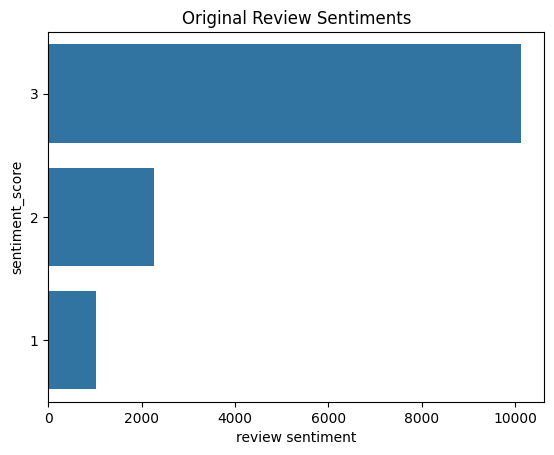

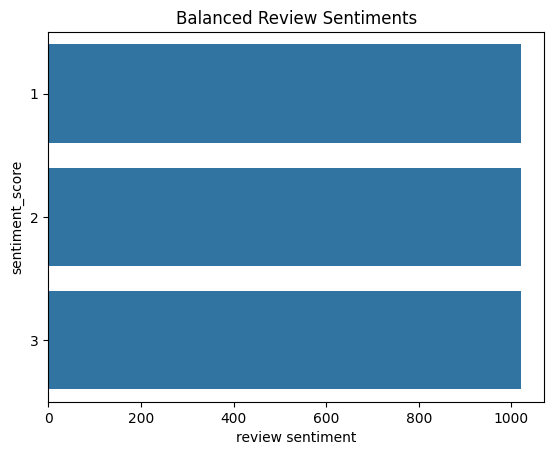

Original dataset size: 13413
Balanced dataset size: 3060
Loading masked dataset:
    Loading existing dataset file @ myanimelist_masked_data.dt...
Loading reviews dataset:
    Loading existing dataset file @ myanimelist_reviews_data.dt...


KeyboardInterrupt: 

In [13]:
reset, pretraining, finetuning = dataset_train_loop("myanimelist")

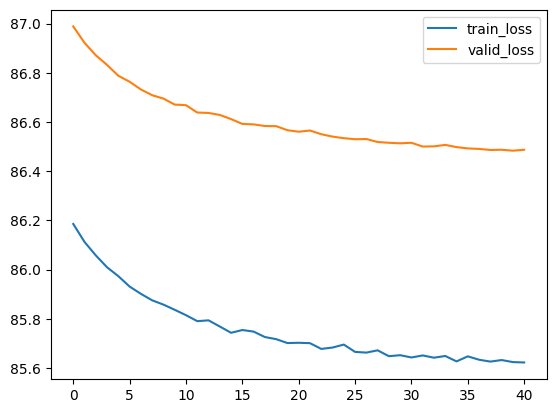

Average delta loss (5 epoch window): -0.0010693504696803302 <= 1000


  0%|          | 0/84 [00:00<?, ?it/s]

In [ ]:
reset()
pretraining()
finetuning(-1000)

## Steam

Training BERT on Steam only.

In [ ]:
dataset_train_loop("steam")

Starting training for steam...
    review_texts: ["Amazing game. Easily 30-40 hours of game play. I hope the dev continues to add more depth in the future! I'd love to see,- More zones, cities, villages etc- Additional starting scenarios (in debt, being a dealer for someone else, certain supplies/drugs not available)- Setups (undercover cops/narcs)- Raids/counter-raids (Police/cartel)- Thief's stealing supplies (if door left open, or employees turning against you)- Mixing drugs with other drugs (weed w/ cocaine)- Turf wars w/ opponent drug-lord organisation charts that you can war with, slowly discover their hierarchy and order hits or do them yourself- High volume deals (shipping supplies off to other regions)", 'For a just "released in early access game" the devs managed to make a game that works, have a fun gameplay loop and satisfying pacing in growth. I would like to see:- a search function in the product management app- a way to change the strain\'s name after the fact, not only 

{'tokenizer': BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), 'model': BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embed

Loading masked dataset:
    Loading existing dataset file @ steam_masked_data.dt...
    Error loading dataset file: [Errno 2] No such file or directory: 'c:\\Users\\Alan\\Desktop\\Open_Source\\BERT-TLSA-paper/data/steam_masked_data.dt'
    Creating new dataset file @ steam_masked_data.dt...


## Metacritic

Training BERT on Metacritic only.

In [ ]:
dataset_train_loop("metacritic")

['Boring game that was soulless even in the beginning. Its contemporaries Roadblocks (why is this censored lol) and Blockland do everything better. Easily the most overrated game of all time.',
 'the best, the only, the unique game in its genre.\nThis game gave me my childhood, THIS IS THE BEST GAME',
 'Not my cup of tea due to so many choices. Still pretty great. Memorable style of world. Diverse & expansive gameplay. Major impact on the industry.',
 'Film He was Very average More I gave Credit By the References And also For the Nostalgia The jokes They are not Funny One Except Put Some well Specific More on al He was Good More or less',
 'Minecraft é muito criativo, dá muita liberdade para os jogadores, possui um vasto lore próprio, muitos detalhes, investimento e desenvolvimento contínuo ao longo de anos após o lançamento, meus amigo sempre gostaram, sempre foi muito popular no youtube e na twitch...\n\nE mesmo assim eu nunca gostei tanto. Talvez pelo gênero de sobrevivência que não

## Rotten Tomatoes

Training BERT on Rotten Tomatoes only.

In [ ]:
dataset_train_loop("rotten_tomatoes")

['Una obra de arte dirigida por Denis Villeneuve. Esta película es una de las mejores que he visto en este género. Sin necesidad de leer los libros, comprenderás a la perfección todo el contexto. El director busca deleitarnos con sus tomas cinematográficas y su espectacular sonido ambiental. Una obra de arte digna de un Oscar. El único problema que le veo, y por el que no le doy un 10, es el comienzo. Puede ser muy tedioso, pero se entiende perfectamente por qué.\n\nConclusión: Esta es una película que definitivamente tienes que ver en algún momento. El comienzo puede ser lento porque te da mucho contexto. No pierdas la oportunidad de verla.\n\nCalificación: 8.5/10',
 'Took me a while to get into it, but as someone who has not read the Dune books, it truly feels like a book. I can see the influence and see how the book must have been like, I definitely plan to read the books at some point. Some of the decisions are a bit sub-par though. They should 100% have had a different cast. Yes, 